In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import numpy as np
from itertools import count
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from deep_translator import GoogleTranslator
from langdetect import detect
import time
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import stanza
import string
from spellchecker import SpellChecker
from collections import defaultdict


# Lectura de Datos

In [2]:
datos = pd.read_excel('Base de datos/Base de datos Chiloe Full.xlsx').reset_index()
datos = datos.rename({'index':'Id'}, axis='columns')

### Descripciones de los campos


1. Id: El ID es un identificador único asignado a cada review de la base de datos. 
2. placeId: El placeId es un identificador único asignado a cada lugar en Google Maps.
3. user name:  El nombre de usuario es el nombre del autor de la reseña en Google Maps. 
4. text: Es el texto escrito por el autor de la reseña para compartir su experiencia o comentarios sobre el lugar.
5. textTranslated: El campo textTranslated contiene la versión traducida al inglés del texto de la reseña.
6. publishedAtDate: Representa la fecha en la que se publicó la reseña en Google Maps.
8. likesCount: Indica la cantidad de "me gusta" o votos positivos recibidos por la reseña.
9. reviewId: reviewId es un identificador único asignado a cada reseña en Google Maps
10. reviewerId: Es el ID del revisor o autor de la reseña en Google Maps. 
11. stars:  Indica la valoración general del lugar en una escala de estrellas, donde 1 es la calificación más baja y 5 es la más  alta.
12. responseFromOwnerDate: Si el propietario o administrador del lugar ha respondido a una reseña, el campo responseFromOwnerDate mostrará la fecha en que se realizó la respuesta.
13. responseFromOwnerText:  Si el propietario o administrador del lugar ha respondido a una reseña, el campo responseFromOwnerText contendrá el texto de la respuesta proporcionada.
lugar. El campo reviewDetailedRating puede contener esta información adicional.
14. hotelStars: Representa la clasificación de estrellas de un hotel específico
15. query: Se refiere a la consulta o búsqueda realizada para obtener las reseñas de Google Maps.
16. place name: Nombre del establecimiento o ubicación para la cual se ha dejado la reseña en Google Maps
17. type:  El campo type indica el tipo general de lugar al que pertenece el establecimiento. Puede ser una categoría amplia como restaurante, hotel, tienda, etc.
18. subtypes: Los subtipos (subtypes) son categorías más específicas que proporcionan información adicional sobre el tipo de lugar. Por ejemplo, si el tipo es restaurante, los subtipos pueden ser italiano, mexicano, sushi, etc. Puede incluir categorías como comida rápida, lujo, económico, spa, etc.
19. city: Indica la ciudad en la que se encuentra el lugar para el cual se ha dejado la reseña en Google Maps.
20. latitude: Representa la coordenada geográfica que indica la ubicación del lugar en el eje vertical. 
21. longitude: Representa la coordenada geográfica que indica la ubicación del lugar en el eje horizontal.
22. rating: Calificación promedio o puntuación general del lugar basada en las reseñas
23. reviews: El campo reviews se refiere a la cantidad total de reseñas disponibles para el lugar. 


# Análisis de datos

## 1. Descripción base de datos

In [3]:
print('Cantidad de Reviews: '+str(len(datos)))
print('Cantidad de Comentarios: ' + str(len(datos['text'].dropna())))
print('Cantidad de Lugares: '+ str(len(datos['placeId'].unique())))
print('Cantidad de usuarios únicos: '+str(len(datos['reviewerId'].unique())))

Cantidad de Reviews: 701964
Cantidad de Comentarios: 344197
Cantidad de Lugares: 2638
Cantidad de usuarios únicos: 262467


In [4]:
datos['publishedAtDate'] = pd.to_datetime(datos['publishedAtDate'])
datos['Year'] = datos['publishedAtDate'].dt.strftime('%Y')
def categoria(palabra):
    return palabra.split(',')[0]

datos['Categoria query'] = datos['query'].apply(categoria)
datos.loc[datos['Categoria query'] == 'Restaurante', 'Categoria query'] = 'restaurant'
datos['Year']=datos['Year'].astype(int)

In [5]:
datos1=datos[datos['Year']>2015]
datos2=datos1[['Id','placeId','place name','Categoria query','Year','text','stars']]
datos3=datos2[datos2['text'].notnull()]
datos3.head()

,Id,placeId,place name,Categoria query,Year,text,stars
2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0
4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0
5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0
6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0
8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0


## 4. Análisis NLP


#### 4.1 Idioma

**Se realizará una detección de idioma para cada comentario**

In [6]:
# Se registra el tiempo de inicio
start = time.time()

# Se define la función detect_language que realiza la detección de idioma de un texto
def detect_language(text):
    try:
        # Se realiza la detección del idioma del texto
        lang = detect(text)
    except:
        # Si falla la detección del idioma, se asume que es español
        lang = 'es'
    return lang

# Se crea una nueva columna 'Idioma' en el DataFrame 'datos3' utilizando la función detect_language
datos3['Idioma'] = datos3['text'].apply(detect_language)

# Se registra el tiempo de finalización
end = time.time()

# Se imprime el tiempo transcurrido
print(end - start)


2536.2129991054535


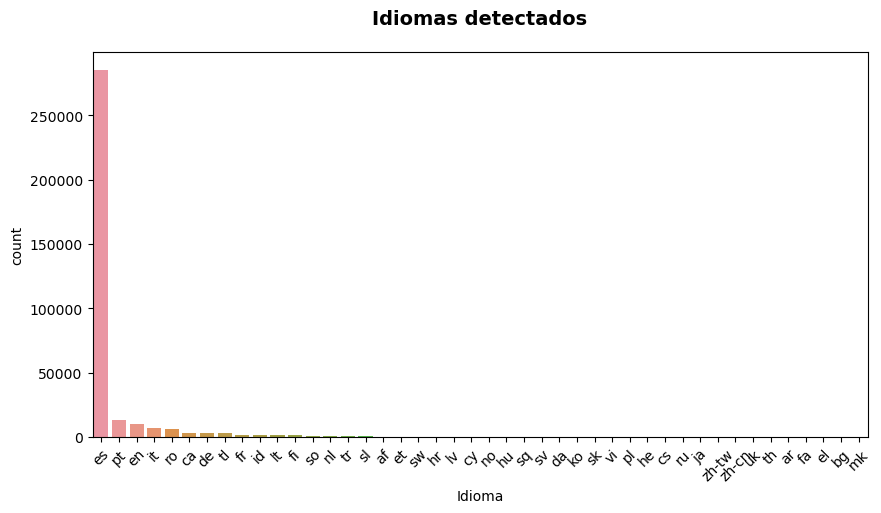

In [7]:
plt.figure(figsize=(10,5))
g=sns.countplot(x=datos3["Idioma"], order = datos3["Idioma"].value_counts().index)
plt.xticks(rotation=45)
plt.title('Idiomas detectados',pad=20, fontweight=700, fontsize=14)
plt.show()

**Para unificar la base de datos se traduce a un solo idioma, en este caso es español, y se deja todo en minuscula**

In [8]:
# Se registra el tiempo de inicio
start = time.time()

# Se crea una columna 'traduccion' en 'datos3' y se inicializa con valor 0
datos3['traduccion'] = 0
datos3 = datos3.reset_index()

# Se itera sobre cada texto en la columna 'text' del DataFrame actual
for indice, j in datos3[['text']].iterrows():
    # Si el idioma no es español (0)
    if datos3['Idioma'].iloc[indice] != 'es':
        # Se traduce el texto a español utilizando Google Translator
        try:
            texto = GoogleTranslator(target='es').translate(text=j[0])
        except:
        # Si ocurre un error, se guarda el texto original en la columna 'traduccion'
            datos3['traduccion'].iloc[indice] = j[0]
    else:
        # Si el idioma ya es español, se mantiene el texto original
        texto = j[0]
    try:
        # Se guarda la traducción en minúsculas en la columna 'traduccion'
        datos3['traduccion'].iloc[indice] = texto.lower()
    except:
        # Si ocurre un error, se guarda el texto original en la columna 'traduccion'
        datos3['traduccion'].iloc[indice] = j[0]

# Se registra el tiempo de finalización
end = time.time()

# Se imprime el tiempo transcurrido
print(end - start)


24288.249220609665


#### 4.2 Clasificación según stars


**A continuación se realizará un recuento de clientes en base a clientes detractores y promotores por cada unidad. Los detractores son aquellos clientes que otorgan una calificación igual o inferior a 2, mientras que los promotores son aquellos clientes que otorgan una calificación igual o superior a 4.**

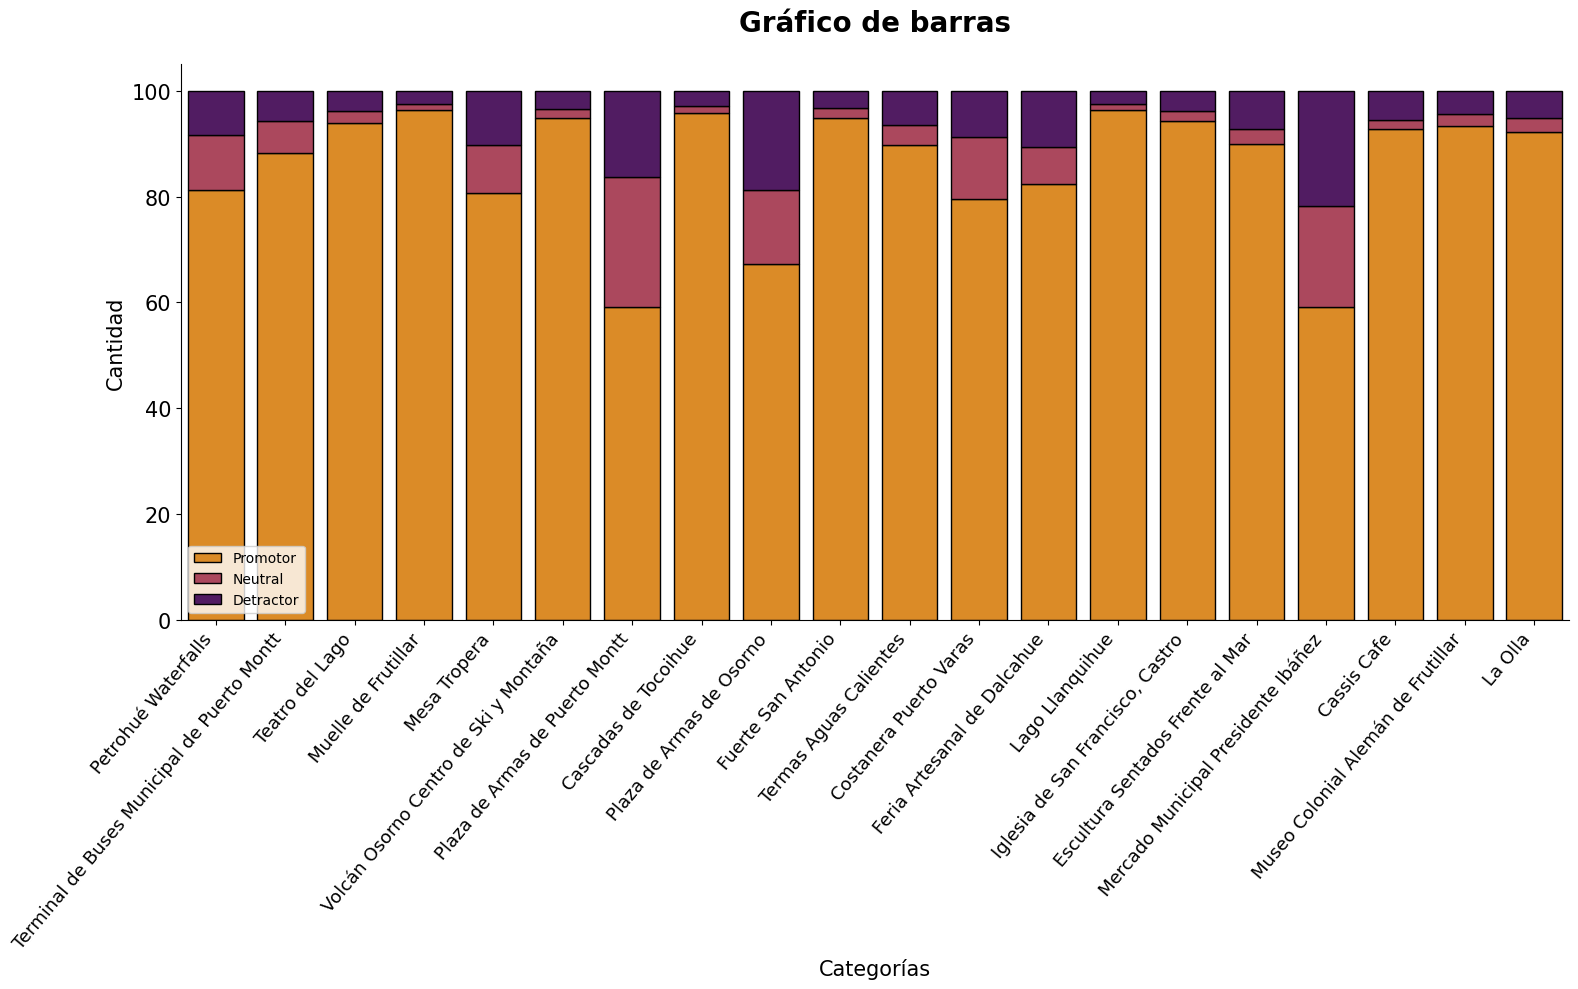

In [9]:
# Se asigna la clasificacion del cliente entre neutral, promotor y detractor

# clientes detractores (calificación igual a 3)
datos3['nps'] = 'neutral'

# clientes detractores (calificación igual o inferior a 2)
datos3['nps'][datos3['stars'] <= 2] = 'detractor'

# clientes promotores (calificación igual o superior a 4)
datos3['nps'][datos3['stars'] >= 4] = 'promotor'

new = datos3.groupby(['placeId','nps']).agg(cantidad=('stars','count')).reset_index()
lugares = datos3.groupby(['placeId'])
for i,j in lugares:
    faltante = list(set(['neutral','promotor','detractor']).difference(j['nps'].unique()))
    for k in faltante:
        new=new.append({'placeId':i,'nps':k,'cantidad':0},ignore_index=True)
        

# Se graficaran aquellos que tienen mayor cantidad de comentarios
top20 = datos3.groupby(['placeId','place name']).agg(cantidad=('text','count')).sort_values(by='cantidad',ascending=False)[0:20]
top20 = top20.reset_index()
new = new.merge(datos3[['placeId','place name']],on='placeId')
new = new[new['placeId'].isin(list(top20['placeId']))].drop_duplicates()

a = np.array(new[new['nps']=='promotor']['cantidad'])
c = np.array(new[new['nps']=='neutral']['cantidad'])
b = np.array(new[new['nps']=='detractor']['cantidad'])
x = list(top20['place name'])
total =np.array(new.groupby(['placeId']).agg(total=('cantidad','sum'))['total'])

a=a/total*100
b=b/total*100
c=c/total*100


def hide_border(ax):
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

df = pd.DataFrame({'Categoría': x,
                   'Promotor': a,
                   'Neutral': b,
                   'Detractor': c})

# Usar Seaborn para crear el gráfico
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
viridis_palette = sns.color_palette("viridis", 3) 
sns.barplot(x='Categoría', y='Promotor', data=df, color='#f98e09', label='Promotor',edgecolor = "black",ax=ax)
sns.barplot(x='Categoría', y='Neutral', data=df, bottom=df['Promotor'], color='#bc3754', label='Neutral',edgecolor = "black",ax=ax)
sns.barplot(x='Categoría', y='Detractor', data=df, bottom=df['Promotor'] + df['Neutral'], color='#57106e', label='Detractor',edgecolor = "black",ax=ax)


ax.set_xlabel('Categorías',fontsize=15)
ax.set_ylabel('Cantidad',fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=50, fontsize=13,ha='right')
ax.set_title('Gráfico de barras',pad=24, fontweight=700, fontsize=20)
plt.yticks(fontsize=15)
hide_border(ax)
ax.legend()  # Show the legend with category labels
fig.tight_layout()


In [10]:
# Se guarda los comentarios traducidos y la nueva clasificación según el rating en un archivo Excel
datos3.to_excel('Base de datos/Traducciones_Los_Lagos.xlsx')  # Guardar la unidad traducida en un archivo Excel
datos3

,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps
0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,"hermoso atractivo turistico, cuanta con sender...",promotor
1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,"muy lindo parque nacional, 100% recomendado, m...",promotor
2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes. un recorrido muy pulcro y...,promotor
3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,"hermoso, vengo a este lugar desde el año 1968....",promotor
4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,"estúpidamente abarrotado, bajos niveles de agu...",detractor
...,...,...,...,...,...,...,...,...,...,...,...
343305,701953,701953,ChIJ6SoI8uU3FpYRcG3nn3N_Rd0,Plaza del Obispado,park,2020,Quite hidden park in the east end of Osorno.,4.0,en,parque bastante escondido en el extremo este d...,promotor
343306,701956,701956,ChIJz9wKu40lGJYRUK33RsKOdt8,Parque De Juegos,park,2021,Na bkn a9Uante barrio azUl,5.0,it,na bkn a9uante barrio azul,promotor
343307,701957,701957,ChIJz9wKu40lGJYRUK33RsKOdt8,Parque De Juegos,park,2021,"Falta mejorar el diseño, limpieza y agregar ju...",3.0,es,"falta mejorar el diseño, limpieza y agregar ju...",neutral
343308,701959,701959,ChIJz9wKu40lGJYRUK33RsKOdt8,Parque De Juegos,park,2020,"Esta todo relativamente bien, pero la iluminac...",2.0,es,"esta todo relativamente bien, pero la iluminac...",detractor


#### 4.3 Análisis de texto

In [11]:
datos3 = pd.read_excel('Base de datos/Traducciones_Los_Lagos.xlsx')

**Se eliminan los ascentos**

In [12]:
datos3['traduccion']=datos3['traduccion'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

**Se pasa todo el texto a minuscula**

In [13]:
datos3['traduccion'] = datos3['traduccion'].str.lower()

**Se realiza un pre procesamiento donde se eliminan lo números, signos de puntuación, espacios al principio y al final de la frase y saltos de línea. También se reemplazan los espacios repetidos por un solo espacio.**

In [14]:
datos3['traduccion'] = datos3['traduccion'].str.replace('\d+', '')
datos3['traduccion'] = datos3['traduccion'].str.translate(str.maketrans(' ', ' ', string.punctuation))
datos3['traduccion'] = datos3['traduccion'].str.strip()
datos3['traduccion'] = datos3['traduccion'].str.replace('\s+',' ')
datos3['traduccion'] = datos3['traduccion'].str.replace('\n',' ')

**Correcciones faltas ortográficas**

In [15]:
# Iniciar el cronómetro
start_time = time.time()
spell = SpellChecker(language=['es','en'])

diccionario_correcciones = defaultdict(list)

for j in datos3['traduccion']:
    palabras = spell.split_words(j)
    misspelled = spell.unknown(palabras)
    
    correcciones = {word: spell.correction(word) for word in misspelled}
    
    for word in palabras:
        correccion = correcciones.get(word, word)
        if correccion != word:
            diccionario_correcciones[correccion].append(word)

# Calcular el tiempo de ejecución
end_time = time.time()
tiempo_ejecucion = end_time - start_time

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")


Tiempo de ejecución: 30901.726775169373 segundos


In [16]:
# Función para obtener el largo de los valores de un diccionario
def obtener_largo_valores(diccionario):
    return [(len(valores), clave) for clave, valores in diccionario.items()]

# Iniciar el cronómetro
start_time = time.time()

# Obtener la lista de tuplas con el largo de la lista y la clave
lista_ordenada = obtener_largo_valores(diccionario_correcciones)

# Ordenar la lista por los largos en orden descendente (de mayor a menor)
lista_ordenada.sort(reverse=True)

# Calcular el tiempo de ejecución
end_time = time.time()
tiempo_ejecucion = end_time - start_time

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")



Tiempo de ejecución: 0.040560007095336914 segundos


Text(0.5, 1.0, 'Cantidad de errores ortográficos por palabra')

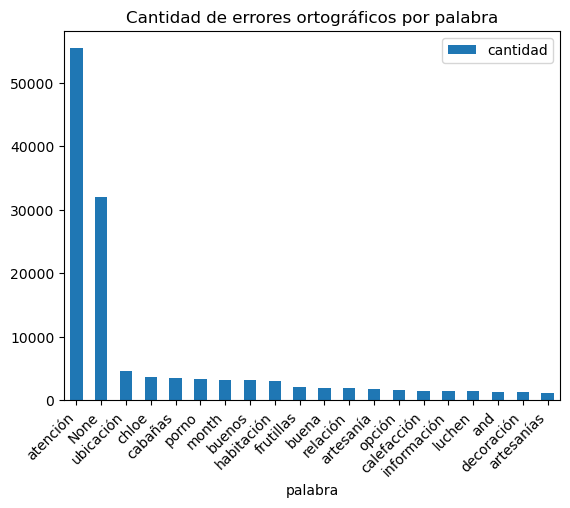

In [17]:
orden = pd.DataFrame(lista_ordenada,columns=['cantidad','palabra'])
orden=orden.set_index('palabra')
orden[0:20].plot(kind='bar')
plt.xticks(rotation = 45,horizontalalignment='right')
plt.title('Cantidad de errores ortográficos por palabra')

In [18]:
def eliminar_elementos_repetidos(diccionario):
    diccionario_modificado = {}
    for clave, lista_valores in diccionario.items():
        lista_sin_repetidos = list(set(lista_valores))
        diccionario_modificado[clave] = lista_sin_repetidos
    return diccionario_modificado

# Llamamos a la función para eliminar los elementos repetidos de las listas en las claves
diccionario_correcciones = eliminar_elementos_repetidos(diccionario_correcciones)



In [19]:
word_replacements = {
    'atencion': ['stencion','atenciion','atencionh','ayencion','atenion','atenacion','atncion','atencian','etencion','atencuon','atencionr','atencio','atenciony',
    'atdncion', 'atenciln', 'arencion', 'atfncion', 'atencipn', 'atencjon', 'atwncion', 'atencionn', 'atenciom', 'atendien' 'atenvion', 'atencios', 'atnecion','atemcion',
    'atenciona''hatencion','atecion','atencien','atenccion','atenciin','atrncion','latencion','aatencion','atencn','atencin','atencixfn','atenxion','atenncion','atebcion'],
    'ubicacion':  ['ubicaci','ubication','ubicacixfn','ubicaciona','ubicacio','ubicacin','unicacion', 'uubicacion','ubucacion','ubicacipn','hubicacion'],
    'trekking': ['treacking', 'treckings', 'treckin', 'trakking','detrekking','treiking','trekkings','treakking','trkking','trekings','trekkinn','trekkin','treking','trekingg','treckking''trekkig','treking','trekkinng','trekkinng','trekkinng','trekkin','treeking','trekkingg','treeking'],
    'dueños': ['duenos'],
    'para':['pa'],
    'tambien':['tb'],
    'artesania': ['artesaniay', 'artesinia', 'astesania', 'aetesania', 'artezania', 'artesania'],
    'lamentablemente': ['lamentablemte', 'lamementablemente', 'lamentablente', 'lamenteblemente', 'lametablemente', 'lamentablemnte', 'lamemtablemente', 'lamentablemwnte', 'lamentablenente','lamentanblemente','lamentablemante', 'lamentablemento'],
    'entrada': ['entraday',  'entraaaa', 'entradita', 'emtrada', 'entreda', 'enrrada', 'entrade',  'entradava',  'entradael', 'entrana',  'enyrada',  'laentrada'],
    'informacion': ['unformacion', 'ingormacion', 'infirmacion', 'informaicon', 'informacin', 'infotmacion', 'infomacion', 'infofmacion', 'informacion', 'informaciony'],
    'hermoso': ['hhermoso','hermaoso', 'hrrmoso', 'herrmozo', 'hermosoel', 'heermosoo', 'hermosito', 'hermosolo', 'hermodo', 'hermosohe', 'hermosoun', 'hermmoso', 'hrmoso',  'jermoso',  'herloso', 'ermosoo', 'bermoso', 'hermocho', 'ermoso', 'hremoso', 'hernoso', 'hermosoy', 'hesmoso',
    'unhermoso', 'hermozoo', 'herboso', 'charmoso', 'heermoso', 'hermoooo', 'hermso', 'hermosooo','hermosoen','hetmoso','hermoosoo', 'hermosoo','herrrmoso','hermostro',
    'hermosome','hermsooo','hermpsoz','herrmoso','heemoso','ermozo','hermosode','hermoao','hormoso','hermozo','heroso','hermosono','germoso','hemroso'],
    'remodelacion': ['remodelasion','remodelaciom','remodelacio','remodelscion','remodelacoon'],
    'Osorno': ['isorno', 'osorno', 'oaorno'],
    'escencia': ['escencis'],
    'imperdible': ['imperdibleun','inperdible','imperdibleno','imperdibile','imprdible','imperdiblee','imperfible','imperdiblelo','imperdivel','umperdible','imperdibley'],
    'vegetacion': ['vegatacion', 'vegeracion','vegetasion','vegetavion','vegetaciob','vejetacion'],
    'turisticos': ['tutisticos'],
    'infraestructura': ['infrestructura','infraestructurano','infraestructora','infraestrucuta','insfraestructura','infraestructuran','infraestructurs','insfraesctructura','infracestructura','infraestectura','infraesctructura','infraectructura','infraestuctura','infraestrucrura','infraestrictura','infrestuctura','infraestrutura','infrawstructura'],
    'mantencion': ['mantemcion','amntencion','mantenckon','mantecion','mantension','mantenciin'],
    'precioso': ['presioso','precioeso','preciosooo','preciosolo','preciosoun','preciosode','preciosol','preciosoel','ptesioso','prrcioso','percioso',
    'preciosimo','preciosome','preciospor','prcioso','preciooso''precuoso','preciiso','previoso','previosko','preciosoo','preccioso'],
    'recomendacion': ['recomendaciony', 'recomendacimo'],
    'sensacion': ['censacion'],
    'montt': ['montr', 'monntt'],
    'hermosos': ['hermososu','hermosose','hrmozos','hermozos','heemosos','hemosos','hermoosos','hermosoes','hermososy','ermosos','hermososi','hemososo','hermosolos','hermososin','hermisos','hermodos'],
    'personales': ['personalen', 'personalel'],
    'maravillosos': ['maravillozos','maeavillosos','maravillososss','maravillosoes','maravillosxs','maravillososin','maravillososu', 'maravillosalos', 'marabillisos', 'maravillosose','maravillosolas'],
    'comparacion': ['cpmparacion', 'comoaracion', 'comapracion'],
    'higienico': ['higenico','higienicos','higienicola','ijienico','higenicos','higenieco','higuienico','higienicono','igienicos','hijenico','igienico','iguienico'],
    'aun': ['ahun', 'auj', 'ayun', 'aug'],
    'personas': ['pwrsonas','personsas','personasde','personassr','personasme','parsonas','perzonas','perosnas','petsonas','personaen','personask','personasen','personan','personnas','perosonas','personasun',
    'personss','personad','personasla','personasy','personasin','perconas','personasa','personaa'],
    'hermosisimo': ['hermosisimoo','hermosisismo','hermosissimo','hermososimo','hernosisimo','hermosisimos'],
    'sandwich': ['sandeich','sanwich','sandwch','samwich','sandwic','samdwich','sanswitch','sandiwsh','sandwinch','sanguich','sandwies','sandwichy','sanwuch','sandich',
    'sandiwish','sandwiche','sandwhich','shandwish','sanduich','samduich','sandwixh','sanduch','sandwuiche','sandwuich','sanwiche','sadwich','sandwish','sanwinch',
    'sandwis','sandwitch', 'sandiuch', 'sanwdich', 'sandwitxh', 'sandwichla', 'sandiwch', 'sandwisch', 'sanduish','swandich'],
    'paradisiaco': ['paradiciaco'],
    'espectacular': ['especatular','especutacular','espectacularun','espectaculat','especracular','epsectacular','espetacular','espectacularla','especatcular','exoectacular',
    'expectaqular','espectaculr','expectacilar','expetacular','espectatular','expectalular','espectaular','espectacularlo','espectacularno','espectacularsi','expecticular',
    'espextacular','expectscular','expectacular','ecpectacular','espectacilar','espectalar','espertacular','expectaxular','espectacula','eapectacular','espectaxular','esperctacular',
    'expestacular','expecatacular','emspectacular','expectcular','espectalucar','aspectacular','expectacurar','espectatcular','espctacular','espectacunar','expertacular',
    'espestacular','rspectacular','esprctacular','expectaclar','espectaculary','espectcular','edpectacular','esoectacular','espectscular'],
    'minusvalidos': ['minisvalidos','minusbalidos'],
    'relacion': ['relscion', 'relaciin', 'relaccion'],
    'recepcion': ['ecepcion','recepciom','resepcion','recpcion','recepcionn','recepciok'],
    'ensueño': ['ensueni', 'ensueno'],
    'recomiendo': ['reomiendo','vrecomiendo','recomiedo','recomiendoa','reclmiendo','reconiendo','lorecomiendo','recomiendome','recomiemdo','recomifndo','recominedo',
    'rrecomiendo','recomiendono','recomiendola','recominendo','revomiendo''recomiwndo','recomiendk','tecomiendo','recomiendoun','remomiendo','recomeniendo',
    'recommiendo','reciomiendo','recomienso','recomiendoal','esrecomiendo','recomiento','recomiendoo','rrcomiendo','rocomiendo','recomindo','recomiendose',
    'recqomiendo','recomuendo','recomiendor','tbrecomiendo','recomiendomm','recomieneon','recomiendoy'],
    'excelente': ['excelenteme','excelenge','exvelente','eexcelente','execelente','exceelnte','exclentr','excelentena','excelenye','excelentedi','ezcelente','excelented',
    'exceleente','escelente','exselente','excelenre','excelene','excelebte','excelenteee','excelentea','excelentelo','exceiente','exceente','exceleste','excelentela',
    'excelnte','excrlente', 'excelentete', 'exxcelente', 'excelete', 'excelentge', 'excelentele', 'excelenteya', 'exclente', 'rxcelente', 'ecxcelente', 'excelecente', 'excalente',   'excelrnte','esxcelente', 'excelentepa',
    'exceldnte','execlente','expelente','exeeelente','excelenteu','excelenteen','eccelente','excemente','excelenteno','excelenta','excelenteel','excelenete','excelemente',
    'excelentee','excenente','exccelente','excelentey','ecxelente','excelenteun','excrlrnte','excleente','dxcelente','ecselente','excelwnte','exxelente',
    'excelemte','excenlente','exlecente','excelento','excelentr','excelebre','excekente','excelentede','exclenete','excenete','excelentw','ecelente','excelenteta'],
    'naturaleza': ['naturalezala','naturalezaa', 'natutaleza','naturalez','naturalezano','natureleza','naturaraleza','naturalezael','naturalesla','natulareza','naturalezaun',
    'nauraleza','naturalezs','naturalezame','nataralesa', 'natuealeza', 'naturakeza','lanaturaleza','naturalrza','nsturaleza','naturalezaby','nturaleza','naturleza','baturaleza','naruraleza','naturalesa','natufsleza'],
    'agua': ['aguael','ahua', 'agui','sgua','aguad','hagua','auga'],
    'turquesa': ['turqueza', 'turquesani'],
    'maravilloso': ['maravillosi','maravillosolo','marbilloso','moravilloso','marsvilloso','maravillosoa','maravillosoya','maravillosoel','mariavilloso','irmaravilloso',
    'maravillloso','maravillosso','maravillosox','maravillosooo','varavimloso','maravolloso','aravilllso','maravilhoso','mraviloso','magavilloso','marivilloso',
    'ymaravilloso','maravillosome', 'maravillozo', 'matavilloso','maravillosono','maraviloso','mravilloso','maravilliso','maravillosoni','mavilloso','maravillosode',
    'maraviyoso','maravillso','marabilloso','maravilllso','maravulloso','maravillosoy','maravillosp','msravilloso','maravillosoo','marvilloso','maravillosoun','maravillosomu','maravillosote','mararavilloso','maravilloro','maaravilloso'],
    'experiencia': ['expierencia', 'esperencia','exepiencia','experienciami','experincia''experienvia','exeriencia','expieriencia','experiemcia','esperiencia','ezperiencia',
    'expeciencia','expiencia','expetiencia','experienzia','laexperiencia','experieacia','experienciaya','experienciade','experienciala','expetiecia','espriencia','experienciano',
    'experiancia','experiencis','experienciay','experiecia','experienciaa','esperiensia','experirncia','ecperiencia','experienciaun','experienciame','experiencial','exoeriencia',
    'expereincia','experiensia','experienciael','experencia','eperiencia'],
    'limpio': ['lienpio','limipio','lmpio','lumpio','limpi','limplio','limnio','limpiode','limpo','limpiome','limpioo','limpioy','limio','limpiono','limpioa','linpio','limpion','nlimpio','limpido','limpiooo','limpoo','limpioun','limplo','limpioe','limpiola'],
    'lugar': ['lugarn',  'kugar','lugaruy','ellugar','luga','lugarv','luhar','lugsr','lugargr','lugal','lugarun','lugartu','lugarmi','lular','luggar','lugaaar','lugarva',
    'lugarq','lugael','lygar','lucar','luvar','lugarma','lugqr','lugarya','sulugar','lugarsu','unlugar','lugaral','lugra','lugarmy','lxgar','luar','lugaf',
    'ougar','lugarr','lugas','lugrar','lugarnr','lugarni','lugat','lugara','lgar','lugare','ugar','llugar','luguar','lusar','nugar','lugarir','lugae','lugarrr','alugar',
    'lugary','lufar','lugay','luugar','lugafr','lugars','lugarar','lugwr','luegar','lugarsi','lugarda','lugaar','lugr','lugarde','lugarno'],
    'buenisimo': ['buenisimooo','buenisomo','buenisimoay','buenisino','buenisimolo','buenisimoy','buenissimoo','buenisiiimo','buenisims','buenicomo','buenizimo', 'buenisimome','buennisimo','buenisimoun',
    'buenicimo','buenisismo','buenisimola','buenisim','buenisimoel','guenisimo','buenissimo''buenisimohe','wuenisimo','buebisimo','wenisimo','bienisimo','burnisimoo','bueniiisimo','buenismo','venisimo'],
    'hermosa': ['hermosoal','hermosaen','hermosp','jermosa','hermosay','hermosaaa','hermosade','hermosola','hermosk','heroza','hremosa','hermlsa','ermoza',
    'hermsa','hermlsl','hermisa','hermosalo','ermosa','hermoaa','hermpsp','hermosea''hermoda','hermoss','hermosael','hernosa','hermoza','hermosala','hetmosa',
    'hermosaa','hermosona','hrmosa','hermosoa','hermsi','hermosame','hermosl','hermosi'],
    'cabañas':['cabanyas', 'cabanasy', 'cabanas'],
    'buenos':['nuenos',  'buenosla','buennos','huenos','buenoslo','ybuenos','vuenos','burnos','wuenos','buenosel','buenoes','bueos','buejos','buebos','buenosy','buenosn','buenosi','guenos','buenose','byenos','rebuenos','buenostb','buemos','buenonos'],
    'habitacion': ['habiltacion','habotacion','abitacion','habitqcion','habiracion'],
    'buena':['bueeena','buenaaa','bueena'',vuena', 'buenaen','guena','byena','buenade','buenael','buenab','beuna','buenale','ybuena','buenad','buenaa','nuena','debuena',
    'buename','buea','mubuena','wuena','buema','huenay','buenap','huena','buenaz','gueena','buwnpa' ,'buenala', 'bueba', 'juena','muena','buenaya','buenay','bena','buenna','bbuena'] ,
    'guardaparques': ['guadaparques','guaradaparques','guardaparuqes','gaurdaparque','guardaparque','guardaparqies','guarsaparques'],
    'lindo': ['lindolo','lindoal','linso','lindl','lindod','iindo','lindalo','lindoa','lindh','limdo','lindi','linao','lindp','lindola','lindii','lindon','linfo','liindo','lindoel','liiindo','unlindo','lindoun','lindono','lindoo','lindooo'], 
    'demasiada': ['demaciada', 'demacisda', 'demasiadaaa'],
    'lugares': ['lugarse','lugarlas','lugaresta','lugaresde','lugards','lugaresy','lugarese','lugareslo','lugaraso','lugarez','lygares','lugarel','lugarves','lugaresel', 'logares','lugsres','lugates','lugaren','lugarsus','lugarea','lugareso'],
    'todo': ['todola','todoo','tooo','atodo','todome','tdoo','todoy','todp','toodo','tooodo','todono','todode','todotv','tofo','todolo','todoa','todoej','todoun','todooo','tpdp','ytodo','todote','todoel'],
    'presentacion': ['presentacion','presantacion','apresentacion','presntacion','presentscion','precentacion','persentacion','presnetacion'],
    'bonito': ['bunito','bnito','binito','bonitido','bonitq','bonit','bonitooo','bonitl','bjnito','bonuto', 'bonitoyo','bonitoy','bonitoel','bonitome','bonitoal','ybonito',
    'bonitola','bonio','boniti','boniyo','banito','bonii','bomito','bonitio','bonitolo','wonito','bonitoo','bonitoa','bonico','bonitoun', 'bonoto','boniton','bonitp','bonitoen'],
    'local': ['locar','lucal','locsl','lokal','lolcal','lical','oocal','lpcal','localy','ellocal','loxal','localun','ylocal','localno'],
    'recomendado': ['revomendado','recomendadode','reconmendado','remomendado','reconendado','recomenddo','recomiendado','recomentado','recomendadoy','recomendadoo','recormendado',
    'rexomendado','recomendadp','recomendato','recomendsdo','recomemdado','recomedado','recomendadimo','recomendadooo','recomendaso' ,'tecomendado'],
    'recomendable': ['reccmendable','recomendableel','recomendablede','reconebdable','recomrndable', 'recomemdable', 'tecomendable','reocmendable','recomomendable','recomendavle','recomentable','recomendableno','recomendabley','rexomendable','recomenfable',
    'recomendadable','recomendabke','reclmendable','recomendaable','remoendable','recolendable','recomedable','recomendableen','recomemdabme','remomendable','reomendable',
    'recomenable','recomenble','recomendablw','recomnedable','recomwndable','rwcomendable','recomebdable','recomnbable','recomdndable','arecomendable','recomendableun','recimenfable',
    'recommendable','recomendabe','recomendableee','rocomnedable','recomenzable','recomendsable','recomendablle','revomendable','recomendablee','recomensable','decomendable',
    'recpmendable','recomdendable','recoemdable','recomendabme','recimendable','recomendablela','reconendable','recomendablelo','reconmendable','rrecomendable','recoemndable',
    'recomendabl','recomendanle','recomendsble','recomendableme','recomendableya','recomndable','recomiendable','recomendablel','racomendable'],
    'fascina':['fasina'],
    'piscina': ['psicina','pisicina','picina','pscina','puscina','pisicna','piscinalo','lapiscina','piscinael','piscecina','piscinad','picsina','pisciba','pisina'],
    'visitar': ['vivitar','visititar','vsitar','visitsr','visotar','visitary','viditar','visitare','viaitar','visistar','vicitar'],
    'atendido':['atebdido','atendidio','atendidi','ayendido','atendidoy','atendidolo','atendidode','atendid','atendidono','atendudo','atendidoya','atendidoun','atendidom','atendodo','atemdido','atendidoel','atendidome','atendidola'],
    'conocer': ['conocerrr','conicer','cococer','conecer','concer','conoser','conoocer'],
    'tranquilo': ['tranquilio','tranquilome','tranqulo','trancilo','tramquilo','trankilo','traquilo','tranquiloy','tanquilo','tranquilonm','tranauilon','tetranquilo','teanquilo',
    'trannquilo','tranquilocy','tranuilo','tranquilon','tranqulio','trenquilo','tranquulo','tranquino','ytranquilo','tranxilo','tranquilode','tranquils','tranqilo','tranquiloa',
    'trnaquilo','tranquili','yranquilo','tranquiloel']
}

def reemplazar_valores(df, columna, diccionario):
    # Verificar que la columna exista en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

    def reemplazar_palabras(palabra):
        for clave, lista_reemplazo in diccionario.items():
            if palabra in lista_reemplazo:
                return clave
        return palabra

    # Separar cada texto en palabras y analizar si hay palabras mal escritas
    df[columna] = df[columna].apply(lambda texto: ' '.join([reemplazar_palabras(palabra) for palabra in texto.split()]))

    return df

# Llamamos a la función para reemplazar los valores del diccionario en la columna 'nombres'
df = datos3.copy()
datos_modificados = reemplazar_valores(df, 'traduccion', word_replacements)

  


### **Se lematizan los comentarios**

In [20]:
nlp = stanza.Pipeline(lang='es',dir='C:/Users/cmurua/stanza_resources',download_method=None)

2023-09-21 07:40:08 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

2023-09-21 07:40:08 INFO: Using device: cpu
2023-09-21 07:40:08 INFO: Loading: tokenize
2023-09-21 07:40:08 INFO: Loading: mwt
2023-09-21 07:40:08 INFO: Loading: pos
2023-09-21 07:40:09 INFO: Loading: lemma
2023-09-21 07:40:09 INFO: Loading: constituency
2023-09-21 07:40:10 INFO: Loading: depparse
2023-09-21 07:40:10 INFO: Loading: sentiment
2023-09-21 07:40:11 INFO: Loading: ner
2023-09-21 07:40:12 INFO: Done loading processors!


In [21]:
# Iniciar el cronómetro
start_time = time.time()

import spacy

# Cargar el modelo de SpaCy en español (asegúrate de que el modelo está instalado)
nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])


# Crear una lista de textos a lematizar
textos_a_lemmatizar = datos_modificados['traduccion'].tolist()

# Procesar en lotes
lemmas_por_lote = []
batch_size = 1000  # Tamaño del lote

for batch_start in range(0, len(textos_a_lemmatizar), batch_size):
    if batch_start%10000==0:
        print(batch_start)
    batch_texts = textos_a_lemmatizar[batch_start:batch_start + batch_size]
    batch_docs = list(nlp.pipe(batch_texts))
    
    for doc in batch_docs:
        lemmas = ' '.join([token.lemma_ for token in doc])
        lemmas_por_lote.append(lemmas)

# Asignar los lemas de vuelta a la columna 'lemmatized'
datos_modificados['lemmatized'] = lemmas_por_lote

# Calcular el tiempo de ejecución
end_time = time.time()
tiempo_ejecucion = end_time - start_time

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
Tiempo de ejecución: 207.33875584602356 segundos


In [22]:
datos_modificados.head()

,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...


In [23]:
datos_modificados.to_csv('Base de datos/datos_lematizados.csv')